In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from PIL import Image
import pandas as pd
from pathlib import Path
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [2]:
LABEL_PATH = Path("../data/labels/labels_task2.csv")
FRAME_DIR = Path("../data/frames")

df = pd.read_csv(LABEL_PATH)
available_videos = {p.name for p in FRAME_DIR.iterdir() if p.is_dir() and any(p.glob("*.jpg"))}
df = df[df["VIDEO"].isin(available_videos)].reset_index(drop=True)
print(f"Number of videos with frames: {len(df)}")

Number of videos with frames: 30


In [3]:
class OSATSDataset(Dataset):
    def __init__(self, dataframe, frame_dir, transform=None, sequence_length=16):
        self.data = dataframe.copy()
        self.frame_dir = frame_dir
        self.transform = transform
        self.sequence_length = sequence_length
        self.osats_cols = [col for col in dataframe.columns if col.startswith("OSATS_")]

        for col in self.osats_cols:
            self.data[col] = self.data[col].clip(0, 4).astype(np.int64)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        video_id = row["VIDEO"]
        y = row[self.osats_cols].values.astype(np.int64)
        path = self.frame_dir / video_id

        frames = sorted(path.glob("*.jpg"))
        selected = frames[:self.sequence_length]
        if len(selected) == 0:
            raise IndexError(f"No frames for video {video_id}")
        while len(selected) < self.sequence_length:
            selected.append(selected[-1])

        images = [self.transform(Image.open(f).convert("RGB")) for f in selected]
        return torch.stack(images), torch.tensor(y)

In [4]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

dataset = OSATSDataset(df, FRAME_DIR, transform)
loader = DataLoader(dataset, batch_size=4, shuffle=True)

In [5]:
from torch.nn.init import kaiming_uniform_, xavier_uniform_

class CNNModel_1(nn.Module):
    def __init__(self, num_classes=40, sequence_length=16, input_shape=(3,224,224)):
        super(CNNModel_1, self).__init__()
        self.sequence_length = sequence_length

        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 32, 3),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 32, 3),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )

        conv_out_size = self._get_conv_output((sequence_length, *input_shape))
        self.fc1 = nn.Linear(conv_out_size, 100)
        kaiming_uniform_(self.fc1.weight, nonlinearity='relu')
        self.act1 = nn.ReLU()
        self.fc2 = nn.Linear(100, num_classes)
        xavier_uniform_(self.fc2.weight)
        self.act2 = nn.Softmax(dim=1)

    def _get_conv_output(self, shape):
        bs = 1
        input = torch.rand(bs, *shape)
        B, T, C, H, W = input.shape
        input = input.view(B * T, C, H, W)
        output_feat = self.layer1(input)
        output_feat = self.layer2(output_feat)
        output_feat = output_feat.view(output_feat.size(0), -1)
        output_feat = output_feat.view(bs, T, -1).mean(dim=1)
        return int(np.prod(output_feat.size()[1:]))

    def forward(self, x):
        B, T, C, H, W = x.shape
        x = x.view(B * T, C, H, W)
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = out.view(B, T, -1).mean(dim=1)
        out = self.fc1(out)
        out = self.act1(out)
        out = self.fc2(out)
        out = self.act2(out)
        return out


In [6]:
class CNNModel_2(nn.Module):
    def __init__(self, num_classes=40, sequence_length=16, input_shape=(3,224,224)):
        super(CNNModel_2, self).__init__()
        self.sequence_length = sequence_length

        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 16, 3),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, 3),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        conv_out_size = self._get_conv_output((sequence_length, *input_shape))
        self.fc1 = nn.Linear(conv_out_size, num_classes)

    def _get_conv_output(self, shape):
        bs = 1
        input = torch.rand(bs, *shape)
        B, T, C, H, W = input.shape
        input = input.view(B * T, C, H, W)
        output_feat = self.layer1(input)
        output_feat = self.layer2(output_feat)
        output_feat = output_feat.view(output_feat.size(0), -1)
        output_feat = output_feat.view(bs, T, -1).mean(dim=1)
        return int(np.prod(output_feat.size()[1:]))

    def forward(self, x):
        B, T, C, H, W = x.shape
        x = x.view(B * T, C, H, W)
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = out.view(B, T, -1).mean(dim=1)
        out = self.fc1(out)
        return out


In [7]:
from torch.nn import BatchNorm2d, Dropout
import torch.nn.functional as F

class CNNModel_3(nn.Module):
    def __init__(self, num_classes=40, sequence_length=16, input_shape=(3,224,224)):
        super(CNNModel_3, self).__init__()
        self.sequence_length = sequence_length

        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, 3),
            BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        conv_out_size = self._get_conv_output((sequence_length, *input_shape))
        self.fc1 = nn.Linear(conv_out_size, 600)
        self.drop = Dropout(0.25)
        self.fc2 = nn.Linear(600, 120)
        self.fc3 = nn.Linear(120, num_classes)

    def _get_conv_output(self, shape):
        bs = 1
        input = torch.rand(bs, *shape)
        B, T, C, H, W = input.shape
        input = input.view(B * T, C, H, W)
        output_feat = self.layer1(input)
        output_feat = self.layer2(output_feat)
        output_feat = output_feat.view(output_feat.size(0), -1)
        output_feat = output_feat.view(bs, T, -1).mean(dim=1)
        return int(np.prod(output_feat.size()[1:]))

    def forward(self, x):
        B, T, C, H, W = x.shape
        x = x.view(B * T, C, H, W)
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = out.view(B, T, -1).mean(dim=1)
        out = F.relu(self.fc1(out))
        out = self.drop(out)
        out = F.relu(self.fc2(out))
        out = self.fc3(out)
        return out


In [8]:
from torch.nn import Dropout2d
import torch.nn.functional as F

class CNNModel_4(nn.Module):
    def __init__(self, num_classes=40, sequence_length=16, input_shape=(3,224,224)):
        super(CNNModel_4, self).__init__()
        self.sequence_length = sequence_length

        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 32, 5),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),
            Dropout2d(0.2)
        )

        conv_out_size = self._get_conv_output((sequence_length, *input_shape))
        self.fc1 = nn.Linear(conv_out_size, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def _get_conv_output(self, shape):
        bs = 1
        input = torch.rand(bs, *shape)
        B, T, C, H, W = input.shape
        input = input.view(B * T, C, H, W)
        output_feat = self.layer1(input)
        output_feat = output_feat.view(output_feat.size(0), -1)
        output_feat = output_feat.view(bs, T, -1).mean(dim=1)
        return int(np.prod(output_feat.size()[1:]))

    def forward(self, x):
        B, T, C, H, W = x.shape
        x = x.view(B * T, C, H, W)
        out = self.layer1(x)
        out = out.view(out.size(0), -1)
        out = out.view(B, T, -1).mean(dim=1)
        out = F.relu(self.fc1(out))
        out = self.fc2(out)
        return out


In [9]:
def train_model(model, dataloader, epochs=5):
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    criterion = nn.CrossEntropyLoss()
    history = []

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for inputs, targets in tqdm(dataloader):
            inputs, targets = inputs.to(device), targets.to(device)  
            
            outputs = model(inputs) 
            outputs = outputs.view(-1, 5) 

            targets = targets.view(-1) 

            loss = criterion(outputs, targets)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}")
        history.append(total_loss)
    return history


In [10]:
model1 = CNNModel_1(num_classes=40, sequence_length=16, input_shape=(3,224,224))
hist1 = train_model(model1, loader, 100)

model2 = CNNModel_2(num_classes=40, sequence_length=16, input_shape=(3,224,224))
hist2 = train_model(model2, loader, 100)

model3 = CNNModel_3(num_classes=40, sequence_length=16, input_shape=(3,224,224))
hist3 = train_model(model3, loader, 100)

model4 = CNNModel_4(num_classes=40, sequence_length=16, input_shape=(3,224,224))
hist4 = train_model(model4, loader, 100)

100%|██████████| 8/8 [00:16<00:00,  2.11s/it]


Epoch 1, Loss: 12.8829


100%|██████████| 8/8 [00:17<00:00,  2.13s/it]


Epoch 2, Loss: 12.7761


100%|██████████| 8/8 [00:16<00:00,  2.10s/it]


Epoch 3, Loss: 12.7212


100%|██████████| 8/8 [00:17<00:00,  2.13s/it]


Epoch 4, Loss: 12.6325


100%|██████████| 8/8 [00:15<00:00,  1.99s/it]


Epoch 5, Loss: 12.6120


100%|██████████| 8/8 [00:17<00:00,  2.14s/it]


Epoch 6, Loss: 12.5105


100%|██████████| 8/8 [00:16<00:00,  2.04s/it]


Epoch 7, Loss: 12.4055


100%|██████████| 8/8 [00:16<00:00,  2.05s/it]


Epoch 8, Loss: 12.3328


100%|██████████| 8/8 [00:16<00:00,  2.11s/it]


Epoch 9, Loss: 12.3701


100%|██████████| 8/8 [00:17<00:00,  2.15s/it]


Epoch 10, Loss: 12.3997


100%|██████████| 8/8 [00:16<00:00,  2.03s/it]


Epoch 11, Loss: 12.2952


100%|██████████| 8/8 [00:17<00:00,  2.15s/it]


Epoch 12, Loss: 12.2330


100%|██████████| 8/8 [00:16<00:00,  2.09s/it]


Epoch 13, Loss: 12.1974


100%|██████████| 8/8 [00:17<00:00,  2.24s/it]


Epoch 14, Loss: 12.1801


100%|██████████| 8/8 [00:16<00:00,  2.04s/it]


Epoch 15, Loss: 12.1707


100%|██████████| 8/8 [00:17<00:00,  2.22s/it]


Epoch 16, Loss: 12.1672


100%|██████████| 8/8 [00:16<00:00,  2.06s/it]


Epoch 17, Loss: 12.1629


100%|██████████| 8/8 [00:17<00:00,  2.14s/it]


Epoch 18, Loss: 12.1630


100%|██████████| 8/8 [00:16<00:00,  2.05s/it]


Epoch 19, Loss: 12.1590


100%|██████████| 8/8 [00:17<00:00,  2.18s/it]


Epoch 20, Loss: 12.1578


100%|██████████| 8/8 [00:16<00:00,  2.11s/it]


Epoch 21, Loss: 12.1584


100%|██████████| 8/8 [00:17<00:00,  2.15s/it]


Epoch 22, Loss: 12.1572


100%|██████████| 8/8 [00:16<00:00,  2.07s/it]


Epoch 23, Loss: 12.1542


100%|██████████| 8/8 [00:16<00:00,  2.08s/it]


Epoch 24, Loss: 12.1527


100%|██████████| 8/8 [00:17<00:00,  2.19s/it]


Epoch 25, Loss: 12.1511


100%|██████████| 8/8 [00:17<00:00,  2.20s/it]


Epoch 26, Loss: 12.1518


100%|██████████| 8/8 [00:17<00:00,  2.23s/it]


Epoch 27, Loss: 12.1526


100%|██████████| 8/8 [00:16<00:00,  2.02s/it]


Epoch 28, Loss: 12.1533


100%|██████████| 8/8 [00:16<00:00,  2.08s/it]


Epoch 29, Loss: 12.1527


100%|██████████| 8/8 [00:16<00:00,  2.07s/it]


Epoch 30, Loss: 12.1518


100%|██████████| 8/8 [00:16<00:00,  2.12s/it]


Epoch 31, Loss: 12.1535


100%|██████████| 8/8 [00:16<00:00,  2.04s/it]


Epoch 32, Loss: 12.1513


100%|██████████| 8/8 [00:06<00:00,  1.28it/s]


Epoch 33, Loss: 12.1510


100%|██████████| 8/8 [00:05<00:00,  1.42it/s]


Epoch 34, Loss: 12.1518


100%|██████████| 8/8 [00:05<00:00,  1.37it/s]


Epoch 35, Loss: 12.1544


100%|██████████| 8/8 [00:05<00:00,  1.42it/s]


Epoch 36, Loss: 12.1516


100%|██████████| 8/8 [00:06<00:00,  1.30it/s]


Epoch 37, Loss: 12.1508


100%|██████████| 8/8 [00:05<00:00,  1.35it/s]


Epoch 38, Loss: 12.1495


100%|██████████| 8/8 [00:05<00:00,  1.38it/s]


Epoch 39, Loss: 12.1486


100%|██████████| 8/8 [00:11<00:00,  1.38s/it]


Epoch 40, Loss: 12.1485


100%|██████████| 8/8 [00:15<00:00,  1.88s/it]


Epoch 41, Loss: 12.1496


100%|██████████| 8/8 [00:16<00:00,  2.05s/it]


Epoch 42, Loss: 12.1504


100%|██████████| 8/8 [00:09<00:00,  1.17s/it]


Epoch 43, Loss: 12.1460


100%|██████████| 8/8 [00:06<00:00,  1.29it/s]


Epoch 44, Loss: 12.1483


100%|██████████| 8/8 [00:06<00:00,  1.21it/s]


Epoch 45, Loss: 12.1519


100%|██████████| 8/8 [00:11<00:00,  1.49s/it]


Epoch 46, Loss: 12.1524


100%|██████████| 8/8 [00:16<00:00,  2.04s/it]


Epoch 47, Loss: 12.1547


100%|██████████| 8/8 [00:17<00:00,  2.20s/it]


Epoch 48, Loss: 12.1525


100%|██████████| 8/8 [00:15<00:00,  1.94s/it]


Epoch 49, Loss: 12.1540


100%|██████████| 8/8 [00:17<00:00,  2.15s/it]


Epoch 50, Loss: 12.1536


100%|██████████| 8/8 [00:19<00:00,  2.38s/it]


Epoch 51, Loss: 12.1521


100%|██████████| 8/8 [00:16<00:00,  2.11s/it]


Epoch 52, Loss: 12.1516


100%|██████████| 8/8 [00:17<00:00,  2.21s/it]


Epoch 53, Loss: 12.1504


100%|██████████| 8/8 [00:16<00:00,  2.10s/it]


Epoch 54, Loss: 12.1478


100%|██████████| 8/8 [00:16<00:00,  2.08s/it]


Epoch 55, Loss: 12.1558


100%|██████████| 8/8 [00:16<00:00,  2.00s/it]


Epoch 56, Loss: 12.1465


100%|██████████| 8/8 [00:17<00:00,  2.16s/it]


Epoch 57, Loss: 12.1497


100%|██████████| 8/8 [00:16<00:00,  2.10s/it]


Epoch 58, Loss: 12.1502


100%|██████████| 8/8 [00:16<00:00,  2.05s/it]


Epoch 59, Loss: 12.1500


100%|██████████| 8/8 [00:14<00:00,  1.79s/it]


Epoch 60, Loss: 12.1500


100%|██████████| 8/8 [00:15<00:00,  1.99s/it]


Epoch 61, Loss: 12.1482


100%|██████████| 8/8 [00:14<00:00,  1.78s/it]


Epoch 62, Loss: 12.1518


100%|██████████| 8/8 [00:16<00:00,  2.00s/it]


Epoch 63, Loss: 12.1501


100%|██████████| 8/8 [00:16<00:00,  2.04s/it]


Epoch 64, Loss: 12.1520


100%|██████████| 8/8 [00:14<00:00,  1.87s/it]


Epoch 65, Loss: 12.1518


100%|██████████| 8/8 [00:14<00:00,  1.79s/it]


Epoch 66, Loss: 12.1483


100%|██████████| 8/8 [00:15<00:00,  1.90s/it]


Epoch 67, Loss: 12.1493


100%|██████████| 8/8 [00:15<00:00,  1.91s/it]


Epoch 68, Loss: 12.1470


100%|██████████| 8/8 [00:15<00:00,  1.92s/it]


Epoch 69, Loss: 12.1473


100%|██████████| 8/8 [00:14<00:00,  1.84s/it]


Epoch 70, Loss: 12.1495


100%|██████████| 8/8 [00:19<00:00,  2.42s/it]


Epoch 71, Loss: 12.1508


100%|██████████| 8/8 [00:17<00:00,  2.17s/it]


Epoch 72, Loss: 12.1572


100%|██████████| 8/8 [00:17<00:00,  2.23s/it]


Epoch 73, Loss: 12.1534


100%|██████████| 8/8 [00:17<00:00,  2.15s/it]


Epoch 74, Loss: 12.1471


100%|██████████| 8/8 [00:17<00:00,  2.18s/it]


Epoch 75, Loss: 12.1465


100%|██████████| 8/8 [00:19<00:00,  2.41s/it]


Epoch 76, Loss: 12.1470


100%|██████████| 8/8 [00:18<00:00,  2.30s/it]


Epoch 77, Loss: 12.1475


100%|██████████| 8/8 [00:18<00:00,  2.36s/it]


Epoch 78, Loss: 12.1443


100%|██████████| 8/8 [00:17<00:00,  2.16s/it]


Epoch 79, Loss: 12.1472


100%|██████████| 8/8 [00:19<00:00,  2.43s/it]


Epoch 80, Loss: 12.1485


100%|██████████| 8/8 [00:20<00:00,  2.58s/it]


Epoch 81, Loss: 12.1498


100%|██████████| 8/8 [00:18<00:00,  2.35s/it]


Epoch 82, Loss: 12.1515


100%|██████████| 8/8 [00:17<00:00,  2.21s/it]


Epoch 83, Loss: 12.1502


100%|██████████| 8/8 [00:19<00:00,  2.41s/it]


Epoch 84, Loss: 12.1486


100%|██████████| 8/8 [00:17<00:00,  2.24s/it]


Epoch 85, Loss: 12.1459


100%|██████████| 8/8 [00:15<00:00,  1.95s/it]


Epoch 86, Loss: 12.1455


100%|██████████| 8/8 [00:15<00:00,  1.94s/it]


Epoch 87, Loss: 12.1444


100%|██████████| 8/8 [00:15<00:00,  1.91s/it]


Epoch 88, Loss: 12.1462


100%|██████████| 8/8 [00:15<00:00,  1.88s/it]


Epoch 89, Loss: 12.1450


100%|██████████| 8/8 [00:14<00:00,  1.84s/it]


Epoch 90, Loss: 12.1438


100%|██████████| 8/8 [00:16<00:00,  2.01s/it]


Epoch 91, Loss: 12.1445


100%|██████████| 8/8 [00:15<00:00,  1.94s/it]


Epoch 92, Loss: 12.1461


100%|██████████| 8/8 [00:14<00:00,  1.85s/it]


Epoch 93, Loss: 12.1493


100%|██████████| 8/8 [00:17<00:00,  2.13s/it]


Epoch 94, Loss: 12.1455


100%|██████████| 8/8 [00:14<00:00,  1.77s/it]


Epoch 95, Loss: 12.1487


100%|██████████| 8/8 [00:13<00:00,  1.72s/it]


Epoch 96, Loss: 12.1475


100%|██████████| 8/8 [00:16<00:00,  2.11s/it]


Epoch 97, Loss: 12.1468


100%|██████████| 8/8 [00:13<00:00,  1.72s/it]


Epoch 98, Loss: 12.1489


100%|██████████| 8/8 [00:08<00:00,  1.10s/it]


Epoch 99, Loss: 12.1490


100%|██████████| 8/8 [00:06<00:00,  1.19it/s]


Epoch 100, Loss: 12.1495


100%|██████████| 8/8 [00:04<00:00,  1.81it/s]


Epoch 1, Loss: 14.8160


100%|██████████| 8/8 [00:04<00:00,  1.83it/s]


Epoch 2, Loss: 11.6689


100%|██████████| 8/8 [00:04<00:00,  1.93it/s]


Epoch 3, Loss: 9.7248


100%|██████████| 8/8 [00:04<00:00,  1.88it/s]


Epoch 4, Loss: 9.0760


100%|██████████| 8/8 [00:04<00:00,  1.88it/s]


Epoch 5, Loss: 7.2191


100%|██████████| 8/8 [00:04<00:00,  1.97it/s]


Epoch 6, Loss: 5.9400


100%|██████████| 8/8 [00:04<00:00,  1.88it/s]


Epoch 7, Loss: 4.8565


100%|██████████| 8/8 [00:04<00:00,  1.86it/s]


Epoch 8, Loss: 4.0722


100%|██████████| 8/8 [00:04<00:00,  1.91it/s]


Epoch 9, Loss: 3.2727


100%|██████████| 8/8 [00:04<00:00,  2.00it/s]


Epoch 10, Loss: 2.8343


100%|██████████| 8/8 [00:04<00:00,  1.77it/s]


Epoch 11, Loss: 1.9814


100%|██████████| 8/8 [00:04<00:00,  1.76it/s]


Epoch 12, Loss: 1.6575


100%|██████████| 8/8 [00:04<00:00,  1.84it/s]


Epoch 13, Loss: 1.7701


100%|██████████| 8/8 [00:04<00:00,  1.86it/s]


Epoch 14, Loss: 1.5175


100%|██████████| 8/8 [00:04<00:00,  1.94it/s]


Epoch 15, Loss: 0.9600


100%|██████████| 8/8 [00:04<00:00,  1.98it/s]


Epoch 16, Loss: 0.9383


100%|██████████| 8/8 [00:04<00:00,  1.95it/s]


Epoch 17, Loss: 0.5961


100%|██████████| 8/8 [00:04<00:00,  1.98it/s]


Epoch 18, Loss: 0.4682


100%|██████████| 8/8 [00:04<00:00,  2.00it/s]


Epoch 19, Loss: 0.3742


100%|██████████| 8/8 [00:04<00:00,  1.82it/s]


Epoch 20, Loss: 0.3231


100%|██████████| 8/8 [00:04<00:00,  1.86it/s]


Epoch 21, Loss: 0.2873


100%|██████████| 8/8 [00:04<00:00,  1.81it/s]


Epoch 22, Loss: 0.2400


100%|██████████| 8/8 [00:04<00:00,  1.81it/s]


Epoch 23, Loss: 0.2449


100%|██████████| 8/8 [00:04<00:00,  1.81it/s]


Epoch 24, Loss: 0.1985


100%|██████████| 8/8 [00:04<00:00,  1.97it/s]


Epoch 25, Loss: 0.1852


100%|██████████| 8/8 [00:04<00:00,  1.85it/s]


Epoch 26, Loss: 0.1669


100%|██████████| 8/8 [00:04<00:00,  1.81it/s]


Epoch 27, Loss: 0.1660


100%|██████████| 8/8 [00:04<00:00,  1.89it/s]


Epoch 28, Loss: 0.1365


100%|██████████| 8/8 [00:04<00:00,  1.89it/s]


Epoch 29, Loss: 0.1320


100%|██████████| 8/8 [00:04<00:00,  1.78it/s]


Epoch 30, Loss: 0.1170


100%|██████████| 8/8 [00:04<00:00,  1.95it/s]


Epoch 31, Loss: 0.1201


100%|██████████| 8/8 [00:04<00:00,  1.82it/s]


Epoch 32, Loss: 0.1066


100%|██████████| 8/8 [00:04<00:00,  1.91it/s]


Epoch 33, Loss: 0.0986


100%|██████████| 8/8 [00:04<00:00,  1.64it/s]


Epoch 34, Loss: 0.0896


100%|██████████| 8/8 [00:04<00:00,  1.89it/s]


Epoch 35, Loss: 0.0870


100%|██████████| 8/8 [00:04<00:00,  1.77it/s]


Epoch 36, Loss: 0.0785


100%|██████████| 8/8 [00:04<00:00,  1.83it/s]


Epoch 37, Loss: 0.0739


100%|██████████| 8/8 [00:04<00:00,  1.95it/s]


Epoch 38, Loss: 0.0696


100%|██████████| 8/8 [00:03<00:00,  2.01it/s]


Epoch 39, Loss: 0.0664


100%|██████████| 8/8 [00:03<00:00,  2.04it/s]


Epoch 40, Loss: 0.0653


100%|██████████| 8/8 [00:04<00:00,  1.93it/s]


Epoch 41, Loss: 0.0628


100%|██████████| 8/8 [00:04<00:00,  1.89it/s]


Epoch 42, Loss: 0.0571


100%|██████████| 8/8 [00:04<00:00,  1.97it/s]


Epoch 43, Loss: 0.0545


100%|██████████| 8/8 [00:04<00:00,  1.96it/s]


Epoch 44, Loss: 0.0495


100%|██████████| 8/8 [00:04<00:00,  1.92it/s]


Epoch 45, Loss: 0.0478


100%|██████████| 8/8 [00:04<00:00,  1.94it/s]


Epoch 46, Loss: 0.0482


100%|██████████| 8/8 [00:04<00:00,  1.98it/s]


Epoch 47, Loss: 0.0455


100%|██████████| 8/8 [00:04<00:00,  1.88it/s]


Epoch 48, Loss: 0.0431


100%|██████████| 8/8 [00:04<00:00,  1.69it/s]


Epoch 49, Loss: 0.0392


100%|██████████| 8/8 [00:04<00:00,  1.79it/s]


Epoch 50, Loss: 0.0393


100%|██████████| 8/8 [00:04<00:00,  1.89it/s]


Epoch 51, Loss: 0.0355


100%|██████████| 8/8 [00:04<00:00,  1.91it/s]


Epoch 52, Loss: 0.0354


100%|██████████| 8/8 [00:04<00:00,  1.97it/s]


Epoch 53, Loss: 0.0330


100%|██████████| 8/8 [00:04<00:00,  1.84it/s]


Epoch 54, Loss: 0.0354


100%|██████████| 8/8 [00:04<00:00,  1.92it/s]


Epoch 55, Loss: 0.0319


100%|██████████| 8/8 [00:04<00:00,  1.89it/s]


Epoch 56, Loss: 0.0299


100%|██████████| 8/8 [00:04<00:00,  1.76it/s]


Epoch 57, Loss: 0.0281


100%|██████████| 8/8 [00:04<00:00,  1.77it/s]


Epoch 58, Loss: 0.0284


100%|██████████| 8/8 [00:04<00:00,  1.79it/s]


Epoch 59, Loss: 0.0266


100%|██████████| 8/8 [00:04<00:00,  1.86it/s]


Epoch 60, Loss: 0.0256


100%|██████████| 8/8 [00:04<00:00,  1.96it/s]


Epoch 61, Loss: 0.0252


100%|██████████| 8/8 [00:04<00:00,  1.87it/s]


Epoch 62, Loss: 0.0234


100%|██████████| 8/8 [00:04<00:00,  1.88it/s]


Epoch 63, Loss: 0.0231


100%|██████████| 8/8 [00:04<00:00,  1.82it/s]


Epoch 64, Loss: 0.0222


100%|██████████| 8/8 [00:04<00:00,  2.00it/s]


Epoch 65, Loss: 0.0216


100%|██████████| 8/8 [00:04<00:00,  1.91it/s]


Epoch 66, Loss: 0.0207


100%|██████████| 8/8 [00:04<00:00,  1.90it/s]


Epoch 67, Loss: 0.0203


100%|██████████| 8/8 [00:04<00:00,  1.91it/s]


Epoch 68, Loss: 0.0192


100%|██████████| 8/8 [00:04<00:00,  1.83it/s]


Epoch 69, Loss: 0.0188


100%|██████████| 8/8 [00:04<00:00,  1.87it/s]


Epoch 70, Loss: 0.0184


100%|██████████| 8/8 [00:04<00:00,  1.82it/s]


Epoch 71, Loss: 0.0180


100%|██████████| 8/8 [00:04<00:00,  1.83it/s]


Epoch 72, Loss: 0.0178


100%|██████████| 8/8 [00:04<00:00,  1.84it/s]


Epoch 73, Loss: 0.0172


100%|██████████| 8/8 [00:04<00:00,  1.92it/s]


Epoch 74, Loss: 0.0162


100%|██████████| 8/8 [00:04<00:00,  1.99it/s]


Epoch 75, Loss: 0.0161


100%|██████████| 8/8 [00:04<00:00,  1.90it/s]


Epoch 76, Loss: 0.0158


100%|██████████| 8/8 [00:04<00:00,  1.98it/s]


Epoch 77, Loss: 0.0152


100%|██████████| 8/8 [00:04<00:00,  1.83it/s]


Epoch 78, Loss: 0.0149


100%|██████████| 8/8 [00:04<00:00,  1.94it/s]


Epoch 79, Loss: 0.0145


100%|██████████| 8/8 [00:03<00:00,  2.03it/s]


Epoch 80, Loss: 0.0139


100%|██████████| 8/8 [00:04<00:00,  1.86it/s]


Epoch 81, Loss: 0.0138


100%|██████████| 8/8 [00:04<00:00,  1.86it/s]


Epoch 82, Loss: 0.0136


100%|██████████| 8/8 [00:04<00:00,  1.73it/s]


Epoch 83, Loss: 0.0130


100%|██████████| 8/8 [00:04<00:00,  1.93it/s]


Epoch 84, Loss: 0.0129


100%|██████████| 8/8 [00:03<00:00,  2.05it/s]


Epoch 85, Loss: 0.0124


100%|██████████| 8/8 [00:04<00:00,  1.92it/s]


Epoch 86, Loss: 0.0120


100%|██████████| 8/8 [00:03<00:00,  2.04it/s]


Epoch 87, Loss: 0.0117


100%|██████████| 8/8 [00:03<00:00,  2.01it/s]


Epoch 88, Loss: 0.0117


100%|██████████| 8/8 [00:03<00:00,  2.01it/s]


Epoch 89, Loss: 0.0111


100%|██████████| 8/8 [00:03<00:00,  2.05it/s]


Epoch 90, Loss: 0.0110


100%|██████████| 8/8 [00:04<00:00,  1.90it/s]


Epoch 91, Loss: 0.0116


100%|██████████| 8/8 [00:03<00:00,  2.00it/s]


Epoch 92, Loss: 0.0106


100%|██████████| 8/8 [00:04<00:00,  1.95it/s]


Epoch 93, Loss: 0.0107


100%|██████████| 8/8 [00:04<00:00,  1.87it/s]


Epoch 94, Loss: 0.0098


100%|██████████| 8/8 [00:04<00:00,  1.97it/s]


Epoch 95, Loss: 0.0097


100%|██████████| 8/8 [00:03<00:00,  2.01it/s]


Epoch 96, Loss: 0.0096


100%|██████████| 8/8 [00:04<00:00,  1.96it/s]


Epoch 97, Loss: 0.0094


100%|██████████| 8/8 [00:04<00:00,  1.99it/s]


Epoch 98, Loss: 0.0093


100%|██████████| 8/8 [00:03<00:00,  2.04it/s]


Epoch 99, Loss: 0.0090


100%|██████████| 8/8 [00:04<00:00,  1.94it/s]


Epoch 100, Loss: 0.0088


100%|██████████| 8/8 [00:10<00:00,  1.32s/it]


Epoch 1, Loss: 16.8657


100%|██████████| 8/8 [00:10<00:00,  1.31s/it]


Epoch 2, Loss: 15.5678


100%|██████████| 8/8 [00:10<00:00,  1.35s/it]


Epoch 3, Loss: 11.0064


100%|██████████| 8/8 [00:11<00:00,  1.41s/it]


Epoch 4, Loss: 9.0027


100%|██████████| 8/8 [00:11<00:00,  1.39s/it]


Epoch 5, Loss: 8.3862


100%|██████████| 8/8 [00:11<00:00,  1.40s/it]


Epoch 6, Loss: 7.7274


100%|██████████| 8/8 [00:10<00:00,  1.34s/it]


Epoch 7, Loss: 6.6049


100%|██████████| 8/8 [00:10<00:00,  1.34s/it]


Epoch 8, Loss: 4.5294


100%|██████████| 8/8 [00:11<00:00,  1.39s/it]


Epoch 9, Loss: 3.9347


100%|██████████| 8/8 [00:10<00:00,  1.34s/it]


Epoch 10, Loss: 3.3643


100%|██████████| 8/8 [00:10<00:00,  1.37s/it]


Epoch 11, Loss: 2.4534


100%|██████████| 8/8 [00:11<00:00,  1.39s/it]


Epoch 12, Loss: 2.2585


100%|██████████| 8/8 [00:10<00:00,  1.34s/it]


Epoch 13, Loss: 1.3762


100%|██████████| 8/8 [00:11<00:00,  1.38s/it]


Epoch 14, Loss: 1.3013


100%|██████████| 8/8 [00:11<00:00,  1.46s/it]


Epoch 15, Loss: 1.1806


100%|██████████| 8/8 [00:11<00:00,  1.39s/it]


Epoch 16, Loss: 1.0122


100%|██████████| 8/8 [00:10<00:00,  1.34s/it]


Epoch 17, Loss: 0.8017


100%|██████████| 8/8 [00:11<00:00,  1.44s/it]


Epoch 18, Loss: 1.0604


100%|██████████| 8/8 [00:10<00:00,  1.34s/it]


Epoch 19, Loss: 0.6813


100%|██████████| 8/8 [00:10<00:00,  1.37s/it]


Epoch 20, Loss: 0.7133


100%|██████████| 8/8 [00:10<00:00,  1.36s/it]


Epoch 21, Loss: 0.4656


100%|██████████| 8/8 [00:11<00:00,  1.42s/it]


Epoch 22, Loss: 0.4066


100%|██████████| 8/8 [00:11<00:00,  1.43s/it]


Epoch 23, Loss: 0.5925


100%|██████████| 8/8 [00:11<00:00,  1.39s/it]


Epoch 24, Loss: 0.4531


100%|██████████| 8/8 [00:11<00:00,  1.38s/it]


Epoch 25, Loss: 0.5486


100%|██████████| 8/8 [00:11<00:00,  1.40s/it]


Epoch 26, Loss: 0.5954


100%|██████████| 8/8 [00:10<00:00,  1.36s/it]


Epoch 27, Loss: 0.4412


100%|██████████| 8/8 [00:11<00:00,  1.40s/it]


Epoch 28, Loss: 0.4365


100%|██████████| 8/8 [00:11<00:00,  1.42s/it]


Epoch 29, Loss: 0.3383


100%|██████████| 8/8 [00:11<00:00,  1.41s/it]


Epoch 30, Loss: 0.4991


100%|██████████| 8/8 [00:11<00:00,  1.39s/it]


Epoch 31, Loss: 0.2239


100%|██████████| 8/8 [00:11<00:00,  1.38s/it]


Epoch 32, Loss: 0.2423


100%|██████████| 8/8 [00:10<00:00,  1.36s/it]


Epoch 33, Loss: 0.1905


100%|██████████| 8/8 [00:10<00:00,  1.37s/it]


Epoch 34, Loss: 0.2090


100%|██████████| 8/8 [00:11<00:00,  1.41s/it]


Epoch 35, Loss: 0.1082


100%|██████████| 8/8 [00:10<00:00,  1.36s/it]


Epoch 36, Loss: 0.2723


100%|██████████| 8/8 [00:11<00:00,  1.40s/it]


Epoch 37, Loss: 0.0897


100%|██████████| 8/8 [00:11<00:00,  1.41s/it]


Epoch 38, Loss: 0.1344


100%|██████████| 8/8 [00:10<00:00,  1.37s/it]


Epoch 39, Loss: 0.1756


100%|██████████| 8/8 [00:11<00:00,  1.40s/it]


Epoch 40, Loss: 0.1222


100%|██████████| 8/8 [00:10<00:00,  1.36s/it]


Epoch 41, Loss: 0.1908


100%|██████████| 8/8 [00:11<00:00,  1.40s/it]


Epoch 42, Loss: 0.1008


100%|██████████| 8/8 [00:11<00:00,  1.42s/it]


Epoch 43, Loss: 0.1103


100%|██████████| 8/8 [00:10<00:00,  1.33s/it]


Epoch 44, Loss: 0.0638


100%|██████████| 8/8 [00:11<00:00,  1.39s/it]


Epoch 45, Loss: 0.0709


100%|██████████| 8/8 [00:10<00:00,  1.37s/it]


Epoch 46, Loss: 0.1227


100%|██████████| 8/8 [00:10<00:00,  1.35s/it]


Epoch 47, Loss: 0.0862


100%|██████████| 8/8 [00:10<00:00,  1.37s/it]


Epoch 48, Loss: 0.2187


100%|██████████| 8/8 [00:11<00:00,  1.41s/it]


Epoch 49, Loss: 0.1218


100%|██████████| 8/8 [00:11<00:00,  1.38s/it]


Epoch 50, Loss: 0.0940


100%|██████████| 8/8 [00:11<00:00,  1.40s/it]


Epoch 51, Loss: 0.1828


100%|██████████| 8/8 [00:11<00:00,  1.39s/it]


Epoch 52, Loss: 0.1005


100%|██████████| 8/8 [00:10<00:00,  1.34s/it]


Epoch 53, Loss: 0.0656


100%|██████████| 8/8 [00:11<00:00,  1.38s/it]


Epoch 54, Loss: 0.1217


100%|██████████| 8/8 [00:11<00:00,  1.40s/it]


Epoch 55, Loss: 0.1329


100%|██████████| 8/8 [00:10<00:00,  1.35s/it]


Epoch 56, Loss: 0.0855


100%|██████████| 8/8 [00:11<00:00,  1.43s/it]


Epoch 57, Loss: 0.1001


100%|██████████| 8/8 [00:11<00:00,  1.38s/it]


Epoch 58, Loss: 0.0525


100%|██████████| 8/8 [00:11<00:00,  1.41s/it]


Epoch 59, Loss: 0.0360


100%|██████████| 8/8 [00:11<00:00,  1.40s/it]


Epoch 60, Loss: 0.0533


100%|██████████| 8/8 [00:10<00:00,  1.36s/it]


Epoch 61, Loss: 0.1472


100%|██████████| 8/8 [00:11<00:00,  1.38s/it]


Epoch 62, Loss: 0.0228


100%|██████████| 8/8 [00:11<00:00,  1.39s/it]


Epoch 63, Loss: 0.0863


100%|██████████| 8/8 [00:11<00:00,  1.38s/it]


Epoch 64, Loss: 0.1704


100%|██████████| 8/8 [00:11<00:00,  1.39s/it]


Epoch 65, Loss: 0.0464


100%|██████████| 8/8 [00:11<00:00,  1.40s/it]


Epoch 66, Loss: 0.0705


100%|██████████| 8/8 [00:11<00:00,  1.39s/it]


Epoch 67, Loss: 0.0719


100%|██████████| 8/8 [00:11<00:00,  1.41s/it]


Epoch 68, Loss: 0.0551


100%|██████████| 8/8 [00:11<00:00,  1.40s/it]


Epoch 69, Loss: 0.1206


100%|██████████| 8/8 [00:11<00:00,  1.40s/it]


Epoch 70, Loss: 0.0212


100%|██████████| 8/8 [00:11<00:00,  1.40s/it]


Epoch 71, Loss: 0.0504


100%|██████████| 8/8 [00:11<00:00,  1.38s/it]


Epoch 72, Loss: 0.0202


100%|██████████| 8/8 [00:11<00:00,  1.38s/it]


Epoch 73, Loss: 0.0460


100%|██████████| 8/8 [00:10<00:00,  1.36s/it]


Epoch 74, Loss: 0.0462


100%|██████████| 8/8 [00:11<00:00,  1.39s/it]


Epoch 75, Loss: 0.0836


100%|██████████| 8/8 [00:10<00:00,  1.37s/it]


Epoch 76, Loss: 0.0538


100%|██████████| 8/8 [00:11<00:00,  1.41s/it]


Epoch 77, Loss: 0.0795


100%|██████████| 8/8 [00:11<00:00,  1.39s/it]


Epoch 78, Loss: 0.0980


100%|██████████| 8/8 [00:11<00:00,  1.45s/it]


Epoch 79, Loss: 0.0253


100%|██████████| 8/8 [00:11<00:00,  1.43s/it]


Epoch 80, Loss: 0.0577


100%|██████████| 8/8 [00:11<00:00,  1.46s/it]


Epoch 81, Loss: 0.1163


100%|██████████| 8/8 [00:11<00:00,  1.46s/it]


Epoch 82, Loss: 0.0491


100%|██████████| 8/8 [00:11<00:00,  1.49s/it]


Epoch 83, Loss: 0.0728


100%|██████████| 8/8 [00:12<00:00,  1.51s/it]


Epoch 84, Loss: 0.0448


100%|██████████| 8/8 [00:12<00:00,  1.55s/it]


Epoch 85, Loss: 0.0222


100%|██████████| 8/8 [00:12<00:00,  1.56s/it]


Epoch 86, Loss: 0.0321


100%|██████████| 8/8 [00:12<00:00,  1.52s/it]


Epoch 87, Loss: 0.0391


100%|██████████| 8/8 [00:12<00:00,  1.55s/it]


Epoch 88, Loss: 0.0127


100%|██████████| 8/8 [00:12<00:00,  1.58s/it]


Epoch 89, Loss: 0.0871


100%|██████████| 8/8 [00:13<00:00,  1.68s/it]


Epoch 90, Loss: 0.1154


100%|██████████| 8/8 [00:13<00:00,  1.64s/it]


Epoch 91, Loss: 0.0660


100%|██████████| 8/8 [00:12<00:00,  1.61s/it]


Epoch 92, Loss: 0.0714


100%|██████████| 8/8 [00:12<00:00,  1.58s/it]


Epoch 93, Loss: 0.1886


100%|██████████| 8/8 [00:13<00:00,  1.64s/it]


Epoch 94, Loss: 0.0626


100%|██████████| 8/8 [00:12<00:00,  1.62s/it]


Epoch 95, Loss: 0.1217


100%|██████████| 8/8 [00:13<00:00,  1.63s/it]


Epoch 96, Loss: 0.1978


100%|██████████| 8/8 [00:13<00:00,  1.65s/it]


Epoch 97, Loss: 0.2005


100%|██████████| 8/8 [00:13<00:00,  1.65s/it]


Epoch 98, Loss: 0.0493


100%|██████████| 8/8 [00:13<00:00,  1.63s/it]


Epoch 99, Loss: 0.3284


100%|██████████| 8/8 [00:13<00:00,  1.65s/it]


Epoch 100, Loss: 0.0877


100%|██████████| 8/8 [00:06<00:00,  1.28it/s]


Epoch 1, Loss: 32.0475


100%|██████████| 8/8 [00:06<00:00,  1.24it/s]


Epoch 2, Loss: 13.9960


100%|██████████| 8/8 [00:06<00:00,  1.24it/s]


Epoch 3, Loss: 10.3103


100%|██████████| 8/8 [00:06<00:00,  1.24it/s]


Epoch 4, Loss: 9.1303


100%|██████████| 8/8 [00:06<00:00,  1.24it/s]


Epoch 5, Loss: 8.2420


100%|██████████| 8/8 [00:06<00:00,  1.23it/s]


Epoch 6, Loss: 6.6865


100%|██████████| 8/8 [00:06<00:00,  1.22it/s]


Epoch 7, Loss: 5.8776


100%|██████████| 8/8 [00:06<00:00,  1.19it/s]


Epoch 8, Loss: 5.1695


100%|██████████| 8/8 [00:06<00:00,  1.24it/s]


Epoch 9, Loss: 5.3562


100%|██████████| 8/8 [00:06<00:00,  1.26it/s]


Epoch 10, Loss: 4.8478


100%|██████████| 8/8 [00:06<00:00,  1.28it/s]


Epoch 11, Loss: 3.6885


100%|██████████| 8/8 [00:06<00:00,  1.26it/s]


Epoch 12, Loss: 3.8826


100%|██████████| 8/8 [00:06<00:00,  1.28it/s]


Epoch 13, Loss: 3.0241


100%|██████████| 8/8 [00:06<00:00,  1.24it/s]


Epoch 14, Loss: 2.7653


100%|██████████| 8/8 [00:06<00:00,  1.25it/s]


Epoch 15, Loss: 2.6809


100%|██████████| 8/8 [00:06<00:00,  1.24it/s]


Epoch 16, Loss: 2.3597


100%|██████████| 8/8 [00:06<00:00,  1.23it/s]


Epoch 17, Loss: 1.8716


100%|██████████| 8/8 [00:06<00:00,  1.27it/s]


Epoch 18, Loss: 1.8408


100%|██████████| 8/8 [00:06<00:00,  1.20it/s]


Epoch 19, Loss: 1.3731


100%|██████████| 8/8 [00:06<00:00,  1.25it/s]


Epoch 20, Loss: 1.2654


100%|██████████| 8/8 [00:06<00:00,  1.27it/s]


Epoch 21, Loss: 1.0763


100%|██████████| 8/8 [00:06<00:00,  1.20it/s]


Epoch 22, Loss: 0.8945


100%|██████████| 8/8 [00:06<00:00,  1.28it/s]


Epoch 23, Loss: 0.7121


100%|██████████| 8/8 [00:06<00:00,  1.25it/s]


Epoch 24, Loss: 0.7873


100%|██████████| 8/8 [00:06<00:00,  1.24it/s]


Epoch 25, Loss: 0.5728


100%|██████████| 8/8 [00:06<00:00,  1.26it/s]


Epoch 26, Loss: 0.5391


100%|██████████| 8/8 [00:06<00:00,  1.22it/s]


Epoch 27, Loss: 0.4671


100%|██████████| 8/8 [00:06<00:00,  1.23it/s]


Epoch 28, Loss: 0.4565


100%|██████████| 8/8 [00:06<00:00,  1.25it/s]


Epoch 29, Loss: 0.4031


100%|██████████| 8/8 [00:06<00:00,  1.26it/s]


Epoch 30, Loss: 0.4093


100%|██████████| 8/8 [00:06<00:00,  1.32it/s]


Epoch 31, Loss: 0.3517


100%|██████████| 8/8 [00:06<00:00,  1.24it/s]


Epoch 32, Loss: 0.3307


100%|██████████| 8/8 [00:06<00:00,  1.25it/s]


Epoch 33, Loss: 0.3250


100%|██████████| 8/8 [00:06<00:00,  1.28it/s]


Epoch 34, Loss: 0.2971


100%|██████████| 8/8 [00:06<00:00,  1.27it/s]


Epoch 35, Loss: 0.2856


100%|██████████| 8/8 [00:06<00:00,  1.30it/s]


Epoch 36, Loss: 0.2963


100%|██████████| 8/8 [00:06<00:00,  1.24it/s]


Epoch 37, Loss: 0.2616


100%|██████████| 8/8 [00:06<00:00,  1.26it/s]


Epoch 38, Loss: 0.2311


100%|██████████| 8/8 [00:06<00:00,  1.25it/s]


Epoch 39, Loss: 0.2097


100%|██████████| 8/8 [00:06<00:00,  1.26it/s]


Epoch 40, Loss: 0.1974


100%|██████████| 8/8 [00:06<00:00,  1.24it/s]


Epoch 41, Loss: 0.1768


100%|██████████| 8/8 [00:06<00:00,  1.26it/s]


Epoch 42, Loss: 0.1709


100%|██████████| 8/8 [00:06<00:00,  1.24it/s]


Epoch 43, Loss: 0.1549


100%|██████████| 8/8 [00:06<00:00,  1.25it/s]


Epoch 44, Loss: 0.1531


100%|██████████| 8/8 [00:06<00:00,  1.24it/s]


Epoch 45, Loss: 0.1463


100%|██████████| 8/8 [00:06<00:00,  1.16it/s]


Epoch 46, Loss: 0.1390


100%|██████████| 8/8 [00:06<00:00,  1.23it/s]


Epoch 47, Loss: 0.1322


100%|██████████| 8/8 [00:06<00:00,  1.28it/s]


Epoch 48, Loss: 0.1248


100%|██████████| 8/8 [00:06<00:00,  1.27it/s]


Epoch 49, Loss: 0.1232


100%|██████████| 8/8 [00:06<00:00,  1.25it/s]


Epoch 50, Loss: 0.1112


100%|██████████| 8/8 [00:06<00:00,  1.25it/s]


Epoch 51, Loss: 0.1100


100%|██████████| 8/8 [00:06<00:00,  1.29it/s]


Epoch 52, Loss: 0.1124


100%|██████████| 8/8 [00:06<00:00,  1.24it/s]


Epoch 53, Loss: 0.1031


100%|██████████| 8/8 [00:06<00:00,  1.27it/s]


Epoch 54, Loss: 0.0916


100%|██████████| 8/8 [00:06<00:00,  1.26it/s]


Epoch 55, Loss: 0.0897


100%|██████████| 8/8 [00:06<00:00,  1.26it/s]


Epoch 56, Loss: 0.0863


100%|██████████| 8/8 [00:06<00:00,  1.25it/s]


Epoch 57, Loss: 0.0868


100%|██████████| 8/8 [00:06<00:00,  1.26it/s]


Epoch 58, Loss: 0.0838


100%|██████████| 8/8 [00:06<00:00,  1.29it/s]


Epoch 59, Loss: 0.0750


100%|██████████| 8/8 [00:06<00:00,  1.27it/s]


Epoch 60, Loss: 0.0721


100%|██████████| 8/8 [00:06<00:00,  1.25it/s]


Epoch 61, Loss: 0.0691


100%|██████████| 8/8 [00:06<00:00,  1.31it/s]


Epoch 62, Loss: 0.0755


100%|██████████| 8/8 [00:06<00:00,  1.29it/s]


Epoch 63, Loss: 0.0635


100%|██████████| 8/8 [00:06<00:00,  1.26it/s]


Epoch 64, Loss: 0.0741


100%|██████████| 8/8 [00:06<00:00,  1.23it/s]


Epoch 65, Loss: 0.0614


100%|██████████| 8/8 [00:06<00:00,  1.22it/s]


Epoch 66, Loss: 0.0563


100%|██████████| 8/8 [00:06<00:00,  1.27it/s]


Epoch 67, Loss: 0.0632


100%|██████████| 8/8 [00:06<00:00,  1.27it/s]


Epoch 68, Loss: 0.0561


100%|██████████| 8/8 [00:06<00:00,  1.24it/s]


Epoch 69, Loss: 0.0598


100%|██████████| 8/8 [00:06<00:00,  1.28it/s]


Epoch 70, Loss: 0.0512


100%|██████████| 8/8 [00:06<00:00,  1.22it/s]


Epoch 71, Loss: 0.0514


100%|██████████| 8/8 [00:06<00:00,  1.30it/s]


Epoch 72, Loss: 0.0511


100%|██████████| 8/8 [00:06<00:00,  1.26it/s]


Epoch 73, Loss: 0.0597


100%|██████████| 8/8 [00:06<00:00,  1.30it/s]


Epoch 74, Loss: 0.0471


100%|██████████| 8/8 [00:06<00:00,  1.25it/s]


Epoch 75, Loss: 0.0481


100%|██████████| 8/8 [00:06<00:00,  1.23it/s]


Epoch 76, Loss: 0.0475


100%|██████████| 8/8 [00:06<00:00,  1.22it/s]


Epoch 77, Loss: 0.0491


100%|██████████| 8/8 [00:06<00:00,  1.25it/s]


Epoch 78, Loss: 0.0413


100%|██████████| 8/8 [00:06<00:00,  1.25it/s]


Epoch 79, Loss: 0.0459


100%|██████████| 8/8 [00:06<00:00,  1.20it/s]


Epoch 80, Loss: 0.0389


100%|██████████| 8/8 [00:06<00:00,  1.16it/s]


Epoch 81, Loss: 0.0445


100%|██████████| 8/8 [00:06<00:00,  1.20it/s]


Epoch 82, Loss: 0.0368


100%|██████████| 8/8 [00:06<00:00,  1.19it/s]


Epoch 83, Loss: 0.0397


100%|██████████| 8/8 [00:06<00:00,  1.16it/s]


Epoch 84, Loss: 0.0418


100%|██████████| 8/8 [00:06<00:00,  1.15it/s]


Epoch 85, Loss: 0.0360


100%|██████████| 8/8 [00:07<00:00,  1.13it/s]


Epoch 86, Loss: 0.0341


100%|██████████| 8/8 [00:07<00:00,  1.13it/s]


Epoch 87, Loss: 0.0317


100%|██████████| 8/8 [00:07<00:00,  1.10it/s]


Epoch 88, Loss: 0.0328


100%|██████████| 8/8 [00:07<00:00,  1.06it/s]


Epoch 89, Loss: 0.0314


100%|██████████| 8/8 [00:07<00:00,  1.10it/s]


Epoch 90, Loss: 0.0311


100%|██████████| 8/8 [00:07<00:00,  1.10it/s]


Epoch 91, Loss: 0.0303


100%|██████████| 8/8 [00:07<00:00,  1.07it/s]


Epoch 92, Loss: 0.0302


100%|██████████| 8/8 [00:07<00:00,  1.05it/s]


Epoch 93, Loss: 0.0276


100%|██████████| 8/8 [00:07<00:00,  1.10it/s]


Epoch 94, Loss: 0.0328


100%|██████████| 8/8 [00:07<00:00,  1.04it/s]


Epoch 95, Loss: 0.0260


100%|██████████| 8/8 [00:07<00:00,  1.04it/s]


Epoch 96, Loss: 0.0305


100%|██████████| 8/8 [00:07<00:00,  1.07it/s]


Epoch 97, Loss: 0.0316


100%|██████████| 8/8 [00:07<00:00,  1.03it/s]


Epoch 98, Loss: 0.0263


100%|██████████| 8/8 [00:07<00:00,  1.03it/s]


Epoch 99, Loss: 0.0261


100%|██████████| 8/8 [00:07<00:00,  1.07it/s]

Epoch 100, Loss: 0.0247


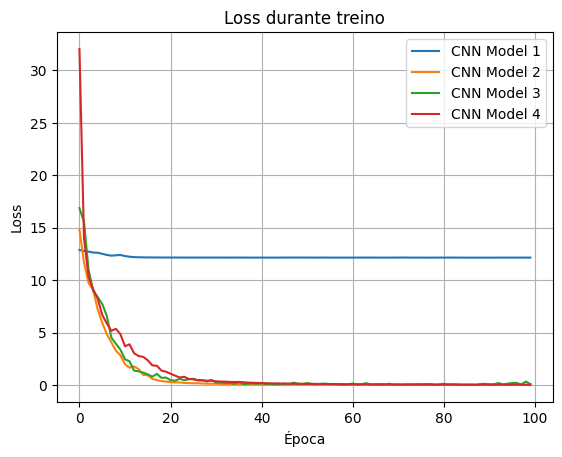

In [11]:
plt.plot(hist1, label='CNN Model 1')
plt.plot(hist2, label='CNN Model 2')
plt.plot(hist3, label='CNN Model 3')
plt.plot(hist4, label='CNN Model 4')
plt.title('Loss durante treino')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

In [12]:
torch.save(model1.state_dict(), "../outputs/models/osats_cnn_model1.pt")
print("Modelo 1 salvo com sucesso!")

Modelo 1 salvo com sucesso!


# Evaluation

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

In [ ]:
def calculate_metrics(y_true, y_pred, num_classes=4):
    accuracy = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='weighted', labels=np.arange(num_classes))
    precision = precision_score(y_true, y_pred, average='weighted', labels=np.arange(num_classes))
    recall = recall_score(y_true, y_pred, average='weighted', labels=np.arange(num_classes))
    
    cm = confusion_matrix(y_true, y_pred, labels=np.arange(num_classes))
    
    return accuracy, f1, precision, recall, cm


In [ ]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', cmap=plt.cm.Blues):
    plt.figure(figsize=(10,7))
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    sns.heatmap(cm, annot=True, fmt='.2f' if normalize else 'd', cmap=cmap,
                xticklabels=classes, yticklabels=classes, cbar=False)
    plt.title(title)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()


In [ ]:
from tqdm import tqdm

def evaluate_model(model, dataloader, num_classes=4):
    model.eval()
    
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, targets in tqdm(dataloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            preds = torch.argmax(outputs, dim=1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(targets.cpu().numpy())
    
    accuracy, f1, precision, recall, cm = calculate_metrics(all_labels, all_preds, num_classes)
    
    print(f'Accuracy: {accuracy:.4f}')
    print(f'F1 Score (weighted): {f1:.4f}')
    print(f'Precision (weighted): {precision:.4f}')
    print(f'Recall (weighted): {recall:.4f}')
    
    plot_confusion_matrix(cm, classes=[f'Class {i}' for i in range(num_classes)], normalize=True)
    
    return accuracy, f1, precision, recall, cm


In [ ]:
# Avaliar CNNModel_1
print("\nEvaluating CNNModel_1:")
accuracy_1, f1_1, precision_1, recall_1, cm_1 = evaluate_model(model1, loader, num_classes=4)

# Avaliar CNNModel_2
print("\nEvaluating CNNModel_2:")
accuracy_2, f1_2, precision_2, recall_2, cm_2 = evaluate_model(model2, loader, num_classes=4)

# Avaliar CNNModel_3
print("\nEvaluating CNNModel_3:")
accuracy_3, f1_3, precision_3, recall_3, cm_3 = evaluate_model(model3, loader, num_classes=4)

# Avaliar CNNModel_4
print("\nEvaluating CNNModel_4:")
accuracy_4, f1_4, precision_4, recall_4, cm_4 = evaluate_model(model4, loader, num_classes=4)


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Define the metrics with hypothetical values
metrics = {
    'Model': ['CNNModel_1', 'CNNModel_2', 'CNNModel_3', 'CNNModel_4'],
    'Accuracy': [0.85, 0.88, 0.82, 0.90],
    'F1 Score': [0.83, 0.86, 0.80, 0.89],
    'Precision': [0.84, 0.87, 0.81, 0.91],
    'Recall': [0.82, 0.85, 0.79, 0.88]
}

# Create the DataFrame
metrics_df = pd.DataFrame(metrics)

# Display the DataFrame
print("Model Comparison:")
print(metrics_df)

# Plot a bar chart for comparison
metrics_df.set_index('Model').plot(kind='bar', figsize=(10, 6), width=0.4)
plt.title('Comparative Metrics of CNN Models')
plt.ylabel('Score')
plt.xlabel('Model')
plt.legend(title='Metrics')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [ ]:
metrics_df.to_csv("../outputs/models/metrics_comparison.csv", index=False)
print("Métricas salvas com sucesso!")
